In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

## A Simple Practical ResNet Project

## 1. Data Operations

### 1.1 Use custom datafile in colab
Upload data to google drive, before accessing it using colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/MyDrive"

 ClassifyLeaves.ipynb  'Colab Notebooks'   torchmodels
 classify-leaves.zip    LeavesData


In [ ]:
!unzip "/content/gdrive/MyDrive/classify-leaves.zip" -d "/content/gdrive/MyDrive/LeavesData";

Archive:  /content/gdrive/MyDrive/classify-leaves.zip
^C


In [ ]:
# Unzipped data is now visible in the output directory
!ls "/content/gdrive/MyDrive/LeavesData"

images	sample_submission.csv  test.csv  train.csv


### 1.2 Create dataset

In this section, we play with our datafiles and create a dataset inherited from python dataset.

#### 1.2.1 View files

In [3]:
# show first five rows of train.csv
labels_dataframe = pd.read_csv("/content/gdrive/MyDrive/LeavesData/train.csv")
labels_dataframe.sample(5) # Use sample to randomly select 5 entries in dataframe

,image,label
15978,images/15978.jpg,acer_griseum
14016,images/14016.jpg,pinus_nigra
14451,images/14451.jpg,prunus_subhirtella
15882,images/15882.jpg,ulmus_pumila
9918,images/9918.jpg,larix_decidua


In [4]:
labels_dataframe.describe()

,image,label
count,18353,18353
unique,18353,176
top,images/2476.jpg,maclura_pomifera
freq,1,353


#### 1.2.2 Map labels
For training, the text labels should be mapped to numbers

In [5]:
# get string labels (without duplicate) and sort
str_labels = sorted(list(set(labels_dataframe['label'])))
# number of classes
n_classes = len(str_labels)
print("Number of classes = ", str(n_classes))
print("\nShow first 5 classes: ")
str_labels[:5]

Number of classes =  176

Show first 5 classes: 


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum']

In [6]:
# Map str_labels to num_labels
str_to_num = dict(zip(str_labels, range(n_classes)))
for i in range(5):
  print(str_labels[i], "=>", str(str_to_num[str_labels[i]]))

abies_concolor => 0
abies_nordmanniana => 1
acer_campestre => 2
acer_ginnala => 3
acer_griseum => 4


In [7]:
# Reverse mapping
num_to_str = {v : k for k, v in str_to_num.items()}
try_i = 120
print(str(try_i), "=>", num_to_str[try_i])

120 => platanus_acerifolia


#### 1.2.3 Create PyTorch dataset

In [8]:
# Inherite from torch.utils.data.Dataset
class LeavesData(Dataset):
    def __init__(self, csv_path, img_folder, mode='train', val_ratio=0.2, resize=256):
        """
        Args:
            csv_path (string): Directory for csv files
            img_folder (string): Directory for image files
            mode (string): 'train' for training, 'val' for validation, 'test' for testing
            val_ratio (float): ratio for validation set
            resize (int): resize the image into target size (resize*resize)
        """
        self.csv_path = csv_path
        self.img_folder = img_folder
        self.mode = mode
        self.val_ratio = val_ratio
        self.resize = resize
        
        # Load csv file
        # First coloumn of the csv file are image file names
        # Second coloumn of the csv file are image labels
        self.csv_data = pd.read_csv(csv_path, header=None)
        # Number of training instances
        self.data_num = len(self.csv_data.index) - 1
        self.train_num = int(self.data_num * (1 - val_ratio))
        
        if mode == 'train':
            self.train_image = np.asarray(self.csv_data.iloc[1:self.train_num, 0])
            self.train_label = np.asarray(self.csv_data.iloc[1:self.train_num, 1])
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'val':
            self.val_image = np.asarray(self.csv_data.iloc[self.train_num:, 0])  
            self.val_label = np.asarray(self.csv_data.iloc[self.train_num:, 1])
            self.image_arr = self.val_image
            self.label_arr = self.val_label
        elif mode == 'test':
            self.test_image = np.asarray(self.csv_data.iloc[1:, 0])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)

        print('Running in {} mode. Number of instances = {}'.format(mode, self.real_len))

    def __getitem__(self, index):
        single_image_name = self.image_arr[index]
        img = Image.open(self.img_folder + single_image_name)

        # Data Augmentation for training
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor()
            ])
        else:
            # No augmentation for validation and testing
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        
        img = transform(img)
        
        if self.mode == 'test':
            return img
        else:
            str_label = self.label_arr[index]
            num_label = str_to_num[str_label]

            return img, num_label

    def __len__(self):
        return self.real_len

In [9]:
train_csv = "/content/gdrive/MyDrive/LeavesData/train.csv"
test_csv = "/content/gdrive/MyDrive/LeavesData/test.csv"
img_folder = "/content/gdrive/MyDrive/LeavesData/"
train_set = LeavesData(train_csv, img_folder, mode='train')
val_set = LeavesData(train_csv, img_folder, mode='val')
test_set = LeavesData(test_csv, img_folder, mode='test')

Running in train mode. Number of instances = 14681
Running in val mode. Number of instances = 3672
Running in test mode. Number of instances = 8800


#### 1.2.4 Create Dataloader

In [10]:
train_loader = DataLoader(
        dataset=train_set,
        batch_size=8, 
        shuffle=True,
        num_workers=2
    )
val_loader = DataLoader(
        dataset=val_set,
        batch_size=8, 
        shuffle=False,
        num_workers=2
    )
test_loader = DataLoader(
        dataset=test_set,
        batch_size=8, 
        shuffle=False,
        num_workers=2
    )

#### 1.2.5 Play with custom dataset

First define the function to display image

In [11]:
def tensor_to_image(tensor):
    
    image = tensor.to("cpu").clone().detach() # Move tensor to cpu and detach
    image = image.numpy().squeeze() 
    image = image.transpose(1,2,0) # tensor size: [3,244,244] => [244,244,3]
    image = image.clip(0, 1) # make the image within range [0,1]

    return image

torch.Size([3, 224, 224])
(224, 224, 3)


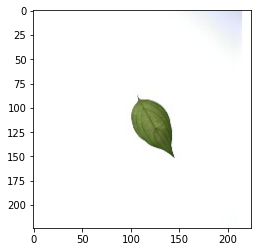

In [12]:
import random

iterator = iter(val_loader)
images, classes = iterator.next()

i = random.randint(0,7)
image_tensor = images[i,:,:,:]
print(image_tensor.size())
image = tensor_to_image(image_tensor)
print(image.shape)
plt.imshow(image)

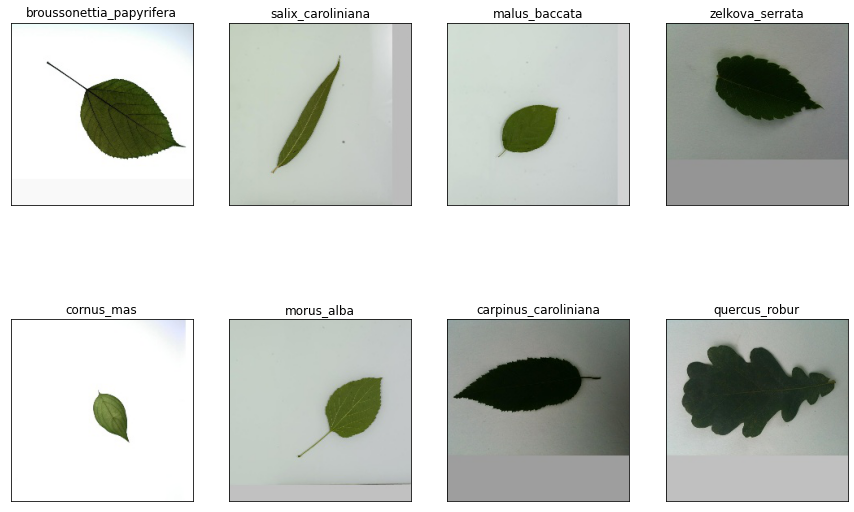

In [13]:
# Plot a batch
iterator = iter(val_loader)
images, classes = iterator.next()

fig = plt.figure(figsize=(15,10))
rows = 2
columns = 4

for idx in range(columns*rows):
  ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
  ax.set_title(num_to_str[int(classes[idx])])
  plt.imshow(tensor_to_image(images[idx]))
plt.show()

## 2. Training

In [14]:
# Check GPU
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

print(get_device())

cuda


### 2.1 Pretrained model

In [15]:
import torchvision.models as models

def set_parameter_requires_grad(model, feature_extracting):
  # This function freezes first fewer layers in a model
    if feature_extracting:
        model = model
        for param in model.parameters():
            param.requires_grad = False

def res_model(num_classes, feature_extract = False, use_pretrained=True):

    model_ft = models.resnet34(pretrained=use_pretrained)
    # Freeze first few layers
    set_parameter_requires_grad(model_ft, feature_extract)
    # Input feature numbers of the last fully connected layer
    num_ftrs = model_ft.fc.in_features
    # Replace the fully connected layer a trainable fc layer
    model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes))

    return model_ft

### 2.2 Training process

In [24]:
device = get_device()

learning_rate = 1e-6
# weight_decay = 1e-3
weight_decay = False
num_epochs = 10

fresh_train = False # True if starting a new train of model
model = res_model(176,feature_extract = True, use_pretrained=False)
model = model.to(device)
model_path = "gdrive/MyDrive/torchmodels/pre_res_model.ckpt"
model.load_state_dict(torch.load(model_path))
model.device = device

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

In [25]:
best_acc = 0
train_acc_curve = []
val_acc_curve = []
for epoch in range(num_epochs):
    ################Train#################
    model.train() # Set model to train mode
    # These are used to record information in training.
    train_loss = []
    train_acc = []
    
    for batch in tqdm(train_loader): # Iterate the training set by batches.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        preds = model(imgs) # Forward propagation
        loss = criterion(preds, labels) # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        
        optimizer.zero_grad() # Clear gradient first
        loss.backward() # Back prop
        optimizer.step() # Update parameters
        
        acc = (preds.argmax(dim=-1) == labels).float().mean() # batch accuracy
        train_loss.append(loss.item())
        train_acc.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_acc) / len(train_acc)
    train_acc_curve.append(train_acc)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{num_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    ################Validation#################
    model.eval() # Set model to evaluation mode
    val_acc = []
    
    for batch in tqdm(val_loader):
        imgs, labels = batch
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            preds = model(imgs.to(device))

        acc = (preds.argmax(dim=-1) == labels.to(device)).float().mean() # batch accuracy
        val_acc.append(acc)

    val_acc = sum(val_acc) / len(val_acc)
    val_acc_curve.append(val_acc)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{num_epochs:03d} ], acc = {val_acc:.5f}")
    
    if not fresh_train and epoch == 0:
      print("Resuming from previous checkpoint")
      best_acc = val_acc
      continue
    # if the model improves, save a tensor_to_imagecheckpoint at this epoch
    if val_acc > best_acc:
        best_acc = val_acc
        print("Fresh Training")
        torch.save(model.state_dict(), model_path)
        print('check point created')

100%|██████████| 1836/1836 [01:42<00:00, 17.92it/s]


[ Train | 001/010 ] loss = 0.21027, acc = 0.95445


100%|██████████| 459/459 [00:24<00:00, 18.59it/s]


[ Valid | 001/010 ], acc = 0.89897
Resuming from previous checkpoint


100%|██████████| 1836/1836 [01:43<00:00, 17.82it/s]


[ Train | 002/010 ] loss = 0.20833, acc = 0.95370


100%|██████████| 459/459 [00:24<00:00, 18.52it/s]


[ Valid | 002/010 ], acc = 0.89788


100%|██████████| 1836/1836 [01:42<00:00, 17.87it/s]


[ Train | 003/010 ] loss = 0.20578, acc = 0.95466


100%|██████████| 459/459 [00:24<00:00, 18.52it/s]


[ Valid | 003/010 ], acc = 0.90005
Fresh Training
check point created


100%|██████████| 1836/1836 [01:43<00:00, 17.82it/s]


[ Train | 004/010 ] loss = 0.20895, acc = 0.95466


100%|██████████| 459/459 [00:24<00:00, 18.53it/s]


[ Valid | 004/010 ], acc = 0.89542


100%|██████████| 1836/1836 [01:42<00:00, 17.86it/s]


[ Train | 005/010 ] loss = 0.21107, acc = 0.95350


100%|██████████| 459/459 [00:24<00:00, 18.53it/s]


[ Valid | 005/010 ], acc = 0.90196
Fresh Training
check point created


100%|██████████| 1836/1836 [01:42<00:00, 17.85it/s]


[ Train | 006/010 ] loss = 0.20811, acc = 0.95527


100%|██████████| 459/459 [00:24<00:00, 18.63it/s]


[ Valid | 006/010 ], acc = 0.89897


100%|██████████| 1836/1836 [01:43<00:00, 17.71it/s]


[ Train | 007/010 ] loss = 0.21281, acc = 0.95234


100%|██████████| 459/459 [00:24<00:00, 18.62it/s]


[ Valid | 007/010 ], acc = 0.89978


100%|██████████| 1836/1836 [01:42<00:00, 17.98it/s]


[ Train | 008/010 ] loss = 0.21161, acc = 0.95343


100%|██████████| 459/459 [00:24<00:00, 18.75it/s]


[ Valid | 008/010 ], acc = 0.89842


100%|██████████| 1836/1836 [01:42<00:00, 17.97it/s]


[ Train | 009/010 ] loss = 0.21015, acc = 0.95513


100%|██████████| 459/459 [00:24<00:00, 18.76it/s]


[ Valid | 009/010 ], acc = 0.89542


100%|██████████| 1836/1836 [01:42<00:00, 17.97it/s]


[ Train | 010/010 ] loss = 0.21421, acc = 0.95255


100%|██████████| 459/459 [00:24<00:00, 18.62it/s]


[ Valid | 010/010 ], acc = 0.89542


## 3. Prediction

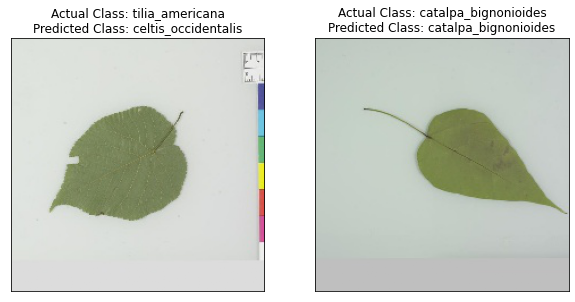

In [28]:
model = res_model(176)

# Load saved model
model = model.to(device)
model.load_state_dict(torch.load(model_path))

val_loader = DataLoader(
        dataset=val_set,
        batch_size=8, 
        shuffle=True,
        num_workers=2
    )

for batch in val_loader:
  images, labels = batch
  images = images.to(device)
  logits = model(images)
  preds = logits.argmax(dim=-1).cpu().numpy().tolist()
  fig = plt.figure(figsize=(10,5))
  for i in range(2):
    image = images[i]
    ax = fig.add_subplot(1, 2, i+1, xticks=[], yticks=[])
    plt.imshow(tensor_to_image(image))
    ax.set_title("Actual Class: {}\nPredicted Class: {}".format(num_to_str[int(labels[i])], num_to_str[int(preds[i])]))
  break

In [ ]:
# model = res_model(176)

# # Load saved model
# model = model.to(device)
# model.load_state_dict(torch.load(model_path))

# # Make sure the model is in eval mode.
# # Some modules like Dropout or BatchNorm affect if the model is in training mode.
# model.eval()
# # Initialize a list to store the predictions.
# predictions = []
# # Iterate the testing set by batches.

# fig = plt.figure(figsize=(15,10))
# rows = 2
# columns = 4

# iterator = iter(test_loader)
# images, classes = iterator.next()

# for idx in range(columns*rows):
#   ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
#   ax.set_title(num_to_str[int(classes[idx])])
#   plt.imshow(im_convert(images[idx]))
# plt.show()
# for batch in tqdm(test_loader):
    
#     imgs = batch
#     with torch.no_grad():
#         logits = model(imgs.to(device))
    
#     # Take the class with greatest logit as prediction and record it.
#     predictions.extend(logits.argmax(dim=-1).cpu().numpy().tolist())

# preds = []
# for i in predictions:
#     preds.append(num_to_str[i])